## Import dependencies

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import sys
import re
import matplotlib.pyplot as plt
import pydicom
import cv2
import glob
import math, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.version
import albumentations as A
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.autograd import Variable
from sklearn.model_selection import KFold, ParameterGrid
from transformers import get_cosine_schedule_with_warmup
from collections import OrderedDict
from tqdm import tqdm
from PIL import Image
from pathlib import Path

IMAGE_SIZE = 512
INPUT_CHANNELS = 30

N_LABELS = 25
N_CLASSES = 3 * N_LABELS

N_FOLDS = 3

GRAD_ACC = 2
TARGET_BATCH_SIZE = 32
TRAIN_BATCH_SIZE = TARGET_BATCH_SIZE // GRAD_ACC
EVAL_BATCH_SIZE = 16

NUM_EPOCHS = 1
START_EPOCH = 0
EARLY_STOP_EPOCH = 3
SAVE_MODEL_EPOCHS = 2

LEARNING_RATE = 2e-5

BASE_FOLDER = './train_images'  # path to the training dataset (modify it according to your setting)
OUTPUT_DIR = './output'  # path to the output directory (modify it according to your setting)
DEVICE = "cuda"
NUM_WORKERS = 4
SEED = 920  # random seed
RESUME = None

/home/ttsai/miniconda3/envs/mulkooo/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def set_random_seed(seed: int = 920, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore

set_random_seed(SEED)

## Load & Read the data

In [3]:
label_coordinates_df = pd.read_csv('./train_label_coordinates.csv')
train_series = pd.read_csv('./train_series_descriptions.csv')
df_train = pd.read_csv('./train.csv')

## Plot a series of images of a patient

In [14]:
def load_dicom_images(folder_path, num_images=5):
    dicom_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.dcm')])[:num_images]
    images = [pydicom.dcmread(f).pixel_array for f in dicom_files]
    return np.stack(images, axis=-1)

# Sagittal T1
folder_path = "./train_images/7143189/3219733239"
Sagittal_T1_images = load_dicom_images(folder_path, num_images=2)
# Sagittal T2/STIR
folder_path = "./train_images/7143189/132939515"
Sagittal_T2_images = load_dicom_images(folder_path, num_images=2)
# Axial T2
folder_path = "./train_images/7143189/1951927562"
Axial_T2_images = load_dicom_images(folder_path, num_images=2)

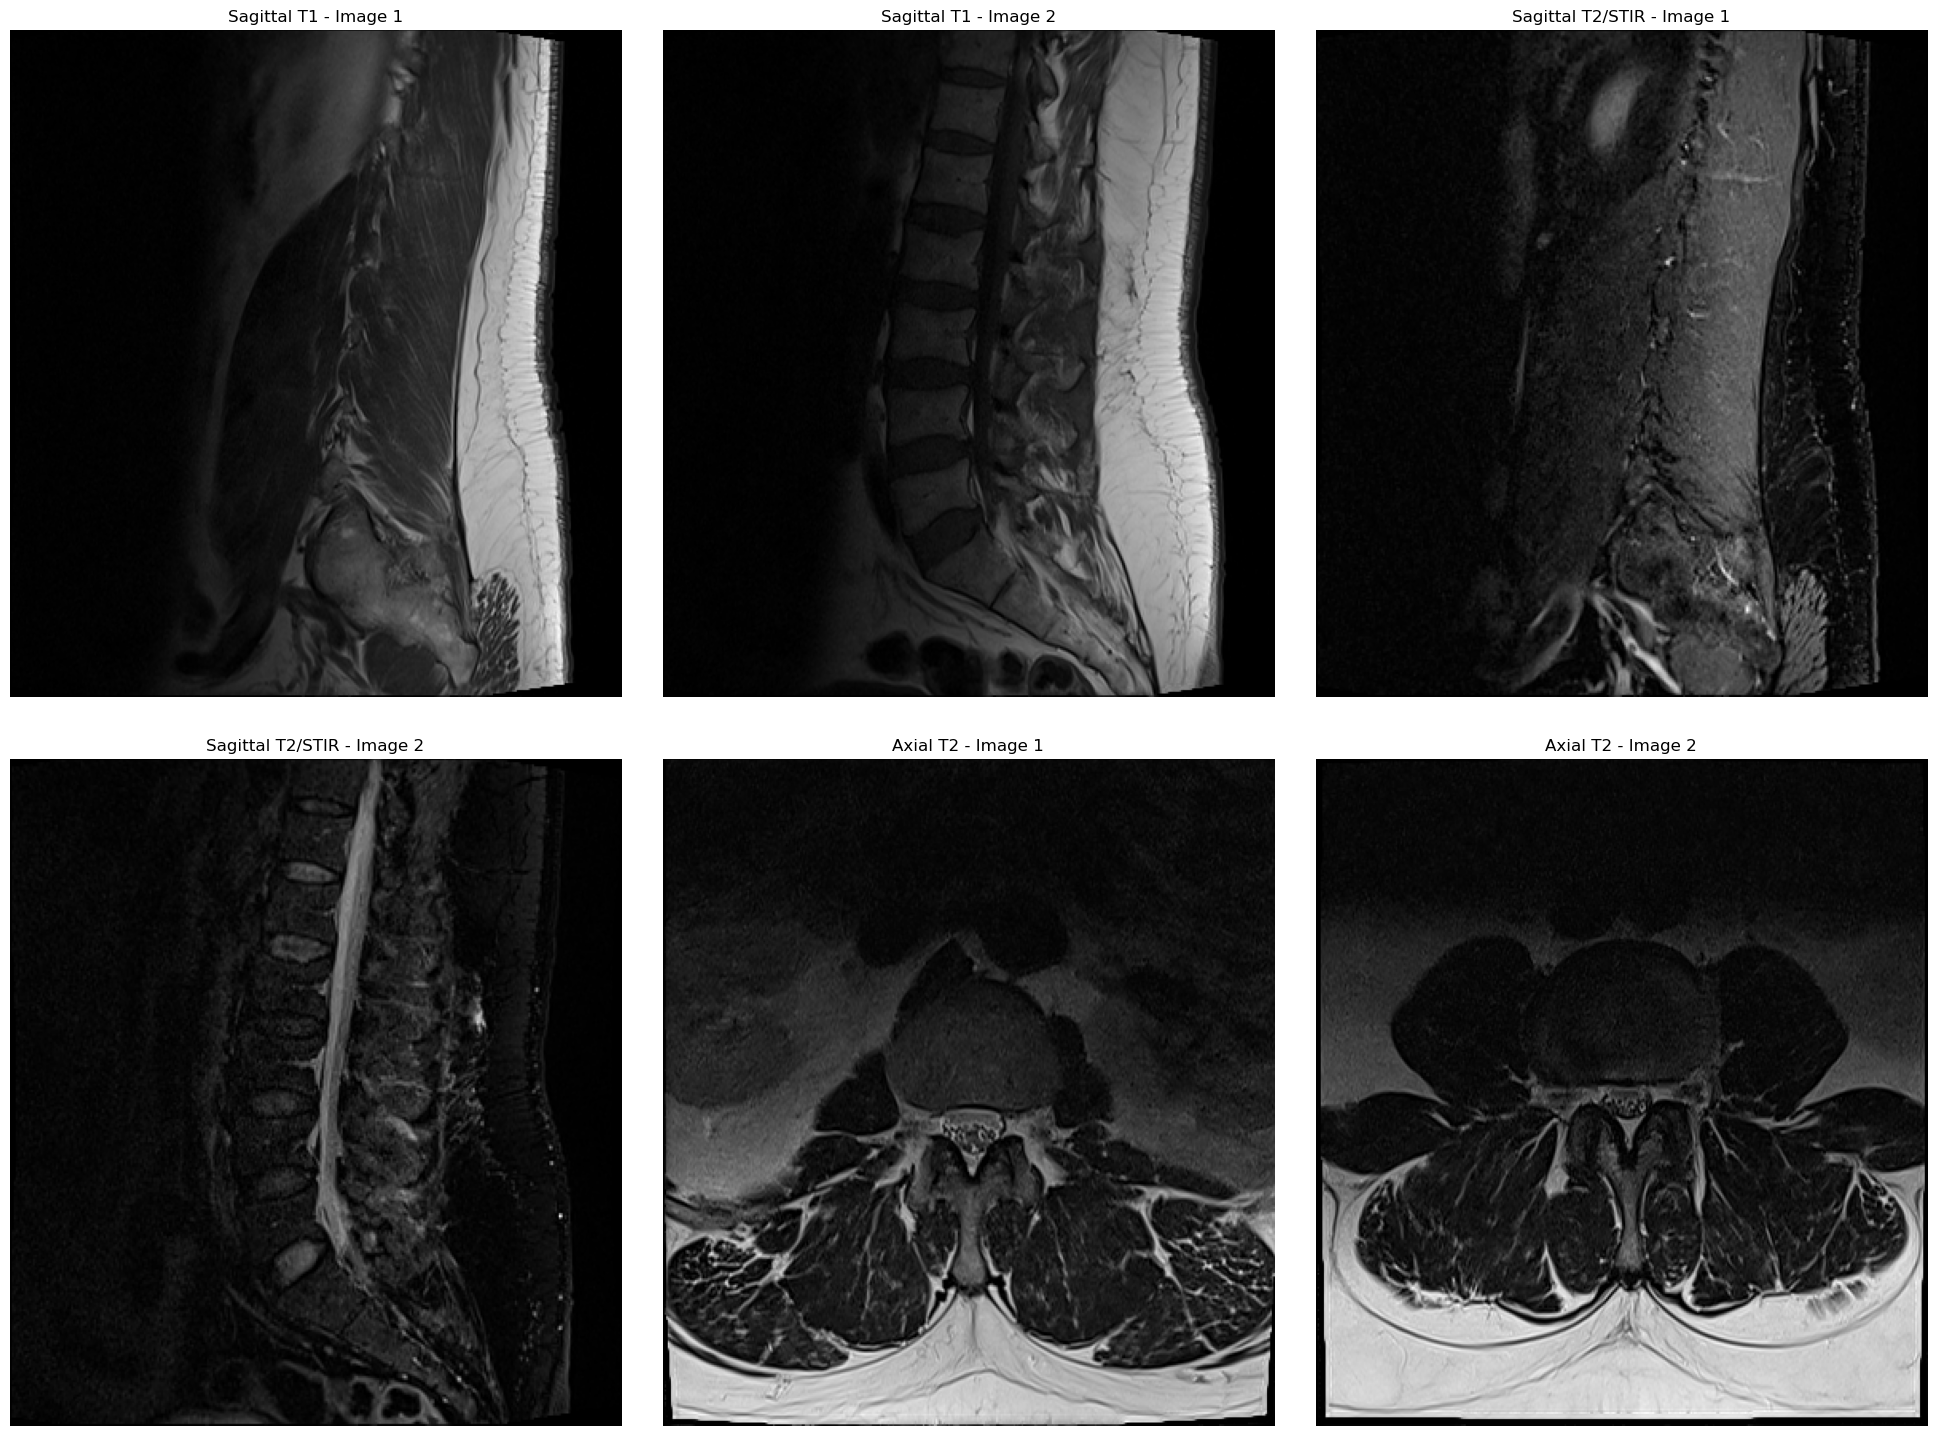

In [20]:
# # Extracting files from a specific study_id
# folder_path = './train_images/100206310/1012284084'
# dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.dcm')]
# label_coordinates_df = pd.read_csv('./train_label_coordinates.csv')

# study_id = folder_path.split('/')[-2]
# study_label_coordinates = label_coordinates_df[label_coordinates_df['study_id'] == int(study_id)]
# filtered_dicom_files = []
# filtered_label_coordinates = []


# for dicom_file in dicom_files:
#     instance_number = int(dicom_file.split('.')[0])
#     corresponding_coordinates = study_label_coordinates[study_label_coordinates['instance_number'] == instance_number]
#     if not corresponding_coordinates.empty:
#         filtered_dicom_files.append(dicom_file)
#         filtered_label_coordinates.append(corresponding_coordinates)

fig, axs = plt.subplots(2, 3, figsize=(20, 15))
# second_row_index = 3
# second_row_images = filtered_dicom_files[second_row_index : second_row_index + 4]
# second_row_coordinates = filtered_label_coordinates[second_row_index : second_row_index + 4]

# for i, (dicom_file, label_coordinates) in enumerate(zip(second_row_images, second_row_coordinates)):
#     dicom_file_path = os.path.join(folder_path, dicom_file)
#     dicom_data = pydicom.dcmread(dicom_file_path)
#     image = dicom_data.pixel_array
#     axs[i].imshow(image, cmap='gray')
#     axs[i].set_title(f'DICOM Image - {dicom_file}')
#     axs[i].axis('off')  
#     # Plotting red dots on the image where the label coordinates indicate
#     for _, row in label_coordinates.iterrows():
#         axs[i].plot(row['x'], row['y'], 'ro', markersize=5) 
        
# plt.tight_layout()
# plt.show()

# Display the images in the grid
axs[0, 0].imshow(Sagittal_T1_images[..., 0], cmap='gray', aspect='auto')
axs[0, 0].set_title('Sagittal T1 - Image 1')
axs[0, 0].axis('off')  # Hide axes

axs[0, 1].imshow(Sagittal_T1_images[..., 1], cmap='gray', aspect='auto')
axs[0, 1].set_title('Sagittal T1 - Image 2')
axs[0, 1].axis('off')

axs[0, 2].imshow(Sagittal_T2_images[..., 0], cmap='gray', aspect='auto')
axs[0, 2].set_title('Sagittal T2/STIR - Image 1')
axs[0, 2].axis('off')

axs[1, 0].imshow(Sagittal_T2_images[..., 1], cmap='gray', aspect='auto')
axs[1, 0].set_title('Sagittal T2/STIR - Image 2')
axs[1, 0].axis('off')

axs[1, 1].imshow(Axial_T2_images[..., 0], cmap='gray', aspect='auto')
axs[1, 1].set_title('Axial T2 - Image 1')
axs[1, 1].axis('off')

axs[1, 2].imshow(Axial_T2_images[..., 1], cmap='gray', aspect='auto')
axs[1, 2].set_title('Axial T2 - Image 2')
axs[1, 2].axis('off')

# Adjust layout to minimize whitespace and maximize image space
plt.tight_layout(pad=3.0)  # Increase pad for better spacing between titles and images
plt.show()

## Making Dataset

In [4]:
# Convert all digit string into int
def atoi(text):
    return int(text) if text.isdigit() else text

# Generate keys(study_id, series_id) for given path
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

study_ids = train_series['study_id'].unique()
sequence_type = list(train_series['series_description'].unique())
bf = BASE_FOLDER

#### Export png from dcm pictures

In [5]:
def dcm_to_png(src_path, output_path):
    dcm_image = pydicom.dcmread(src_path)
    image = dcm_image.pixel_array
    image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255 # Normalize to range(0, 255)

    # Resize and reshape image
    img = cv2.resize(np.array(image), (512, 512), interpolation=cv2.INTER_CUBIC)
    assert img.shape==(512, 512)
    cv2.imwrite(output_path, img)

In [25]:
for idx, si in enumerate(tqdm(study_ids, total=len(study_ids))):
    df_si = train_series[train_series['study_id'] == si] # Traverse every study_ids
    for ds in sequence_type:
        ds_path = ds.replace('/', '_')
        df_si_ds = df_si[df_si['series_description'] == ds]
        os.makedirs(f'./cvt_png/{si}/{ds_path}', exist_ok=True)

        all_images = []

        for i, row in df_si_ds.iterrows():
            img_paths = glob.glob(f"{bf}/{row['study_id']}/{row['series_id']}/*.dcm")
            img_paths = sorted(img_paths, key = natural_keys)
            all_images.extend(img_paths)

        if len(all_images) == 0:
            print(si, ds, 'has no image')
            continue
        
        # Order Axial images could be tricky, sample them while training would be better choice
        if ds == 'Axial T2':
            for j, img_path in enumerate(all_images):
                output_path = f'./cvt_png/{si}/{ds}/{j:03d}.png'
                dcm_to_png(img_path, output_path)

        # For the other two types of sequence, select them in an interval
        elif ds == 'Sagittal T2/STIR':
            step = len(all_images) / 10.0
            start = len(all_images) / 2.0 - 4.0 * step # Start slightly off the mid point
            end = len(all_images) + 0.0001 # To include the end
            for j, i in enumerate(np.arange(start, end, step)):
                output_path = f'./cvt_png/{si}/{ds_path}/{j:03d}.png'
                idx = max(0, int((i - 0.5001).round())) # Kind of floor the selected indecies
                dcm_to_png(all_images[idx], output_path)
            assert len(glob.glob(f'./cvt_png/{si}/{ds_path}/*.png')) == 10 # Raise AssertionError when there's not exactly 10 pngs

        elif ds == 'Sagittal T1':
            step = len(all_images) / 10.0
            start = len(all_images) / 2.0 - 4.0 * step # Start slightly off the mid point
            end = len(all_images) + 0.0001 # To include the end
            for j, i in enumerate(np.arange(start, end, step)):
                output_path = f'./cvt_png/{si}/{ds}/{j:03d}.png'
                idx = max(0, int((i - 0.5001).round())) # Kind of floor the selected indecies
                dcm_to_png(all_images[idx], output_path)
            assert len(glob.glob(f'./cvt_png/{si}/{ds_path}/*.png')) == 10 # Raise AssertionError when there's not exactly 10 pngs

 57%|█████▋    | 1126/1975 [06:45<04:20,  3.26it/s]

2492114990 Sagittal T1 has no image


 64%|██████▍   | 1272/1975 [07:34<03:36,  3.24it/s]

2780132468 Sagittal T1 has no image


 70%|██████▉   | 1378/1975 [08:12<02:59,  3.33it/s]

3008676218 Sagittal T2/STIR has no image


100%|██████████| 1975/1975 [11:40<00:00,  2.82it/s]


## Training Dataset

In [24]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print(torch.version.cuda)
    print(torch.__version__)
else:
    device = torch.device("cpu")
    print("GPU is not available")

# Replace na values
df_train = df_train.fillna(-100)

# Transform label to label_int (ex. Normal/Mild -> 0)
label_to_value = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}
count_0 = (df_train == 0).sum().sum()
count_1 = (df_train == 1).sum().sum()
count_2 = (df_train == 2).sum().sum()
por_2 = count_2 / (count_0 + count_1)
df_train = df_train.replace(label_to_value)

# Define dataset and data loader
class TrainDataset(Dataset):
    def __init__(self, df_train, phase='training', transform=None):
        self.df = df_train
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        images = np.zeros((IMAGE_SIZE, IMAGE_SIZE, INPUT_CHANNELS), dtype=np.uint8)
        row = self.df.iloc[idx]
        study_id = int(row['study_id'])
        cases = [2492114990, 2780132468, 3008676218]
        ignore_case = True if study_id in cases else False
        label = row[1:].values.astype(np.int64) # Label value for 25 classes (5 conditions * 5 levels)
        
        # Sagittal T1
        for i in range(0, 10, 1):
            try:
                png = f'./cvt_png/{study_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(png).convert('L')
                img = np.array(img)
                images[..., i] = img.astype(np.uint8)
            except:
                if not ignore_case:
                    print(f'failed to load on {study_id}, Sagittal T1')
                pass

        # Sagittal T2/STIR
        for i in range(0, 10, 1):
            try:
                png = f'./cvt_png/{study_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(png).convert('L')
                img = np.array(img)
                images[..., i + 10] = img.astype(np.uint8)
            except:
                if not ignore_case:
                    print(f'failed to load on {study_id}, Sagittal T2_STIR')
                pass

        # Axial T2
        axt2 = glob.glob(f'./cvt_png/{study_id}/Axial T2/*.png')
        axt2 = sorted(axt2, key=natural_keys)

        step = len(axt2) / 10.0
        start = len(axt2) / 2.0 - 4.0 * step
        end = len(axt2) + 0.0001

        for j, i in enumerate(np.arange(start, end, step)):
            try:
                png_path = axt2[max(0, int((i - 0.5001).round()))]
                img = Image.open(png_path).convert('L')
                img = np.array(img)
                images[..., j + 20] = img.astype(np.uint8)
            except:
                if not ignore_case:
                    print(f'failed to load on {study_id}, Axial T2')
                pass  
            
        assert np.sum(images) > 0

        if self.transform is not None:
            images = self.transform(image = images)['image']
        
        images = images.transpose(2, 0, 1) # Let input channels be the first axis

        return images, label


GPU is available
12.1
2.4.0


In [16]:
# Test functionalities of the dataset

dataset = TrainDataset(df_train=df_train)
images, label = dataset[1]

## Transform for Training and Validation

In [6]:
AUG = True
AUG_PROB = 0.75

transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=0.5, std=0.5)
])

/home/ttsai/miniconda3/envs/mulkooo/lib/python3.11/site-packages/pydantic/main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.4510) tensor(-0.9158) tensor(0.1859)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


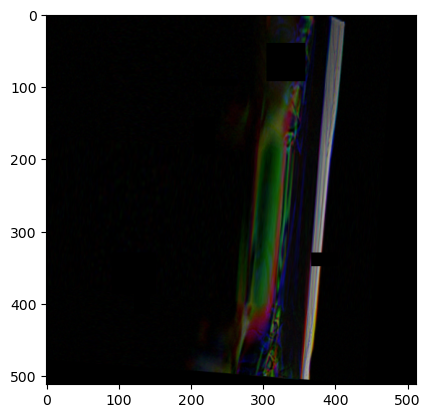

y stat: (512, 512, 3) 0.0 0.7058824 0.03133992 0.08496365

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9922) tensor(-0.5131) tensor(0.3231)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


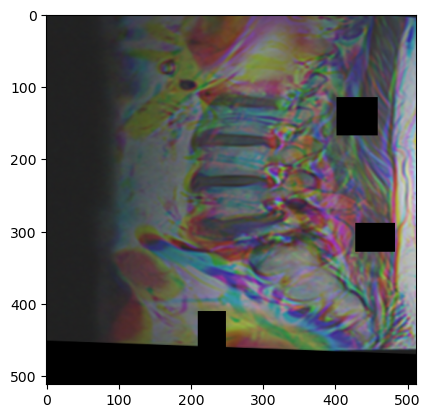

y stat: (512, 512, 3) 0.0 0.92549026 0.28635803 0.17598467

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.5551) tensor(0.4680)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


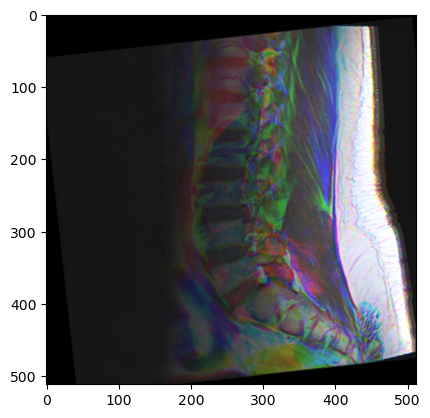

y stat: (512, 512, 3) 0.0 1.0 0.23910816 0.25017864

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.7268) tensor(0.4592)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


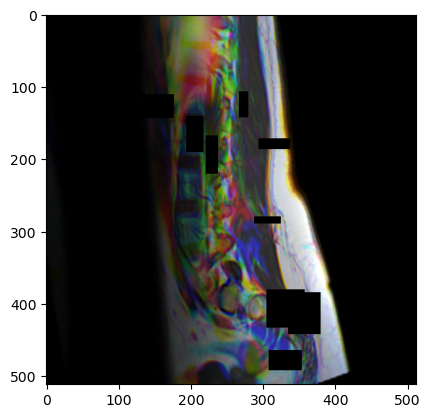

y stat: (512, 512, 3) 0.0 1.0 0.12369674 0.21218559

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9843) tensor(-0.5048) tensor(0.3949)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0]]) torch.Size([1, 25])


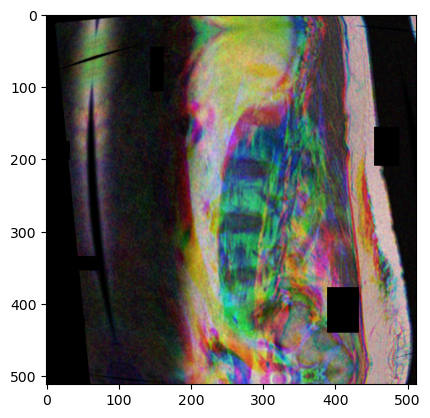

y stat: (512, 512, 3) 0.0 0.99215686 0.2930822 0.24593961



In [21]:
# Test functionalities of the dataset and dataloader
tmp_ds = TrainDataset(df_train=df_train, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==5:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy().transpose(0,2,3,1)[0,...,:3]
    y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

## Define Model

In [7]:
# Define the DenseNet block with batch normalization and ReLU
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        return torch.cat((x, out), 1)

# Define the transition layer with batch normalization and average pooling
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.bn(x)
        out = self.relu(out)
        out = self.conv(out)
        out = self.avgpool(out)
        return out

# Define the DenseNet model
class DenseNet(nn.Module):
    def __init__(self, num_classes=75, input_channels=30, growth_rate=32, num_blocks=[6, 12, 24, 16], theta=0.5):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_classes = num_classes
        self.input_channels = input_channels

        # Initial convolution layer
        self.conv1 = nn.Conv2d(input_channels, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Blocks
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            block = self._make_dense_block(in_channels, num_layers)
            setattr(self, f'denseblock{i + 1}', block)
            in_channels += num_layers * growth_rate
            if i < len(num_blocks) - 1:
                transition = self._make_transition_layer(in_channels, int(in_channels * theta))
                setattr(self, f'transition{i + 1}', transition)
                in_channels = int(in_channels * theta)

        # Final layers
        self.bn_final = nn.BatchNorm2d(in_channels)
        self.relu_final = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def _make_dense_block(self, in_channels, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(DenseBlock(in_channels + i * self.growth_rate, self.growth_rate))
        return nn.Sequential(*layers)

    def _make_transition_layer(self, in_channels, out_channels):
        return TransitionLayer(in_channels, out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        for i in range(4):
            x = getattr(self, f'denseblock{i + 1}')(x)
            if i < 3:
                x = getattr(self, f'transition{i + 1}')(x)
        x = self.bn_final(x)
        x = self.relu_final(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [15]:
# Try if model works properly
m = DenseNet(num_classes=N_CLASSES, input_channels=INPUT_CHANNELS)
i = torch.randn(16, INPUT_CHANNELS, 512, 512)
targets = torch.randint(0, 3, (16,))  # True class indices
out = m(i)

for o in out:
    print(o.shape, o.min(), o.max(), o)

pred = out[:, 2*3:2*3 + 3]
print(pred)

torch.Size([75]) tensor(-0.7414, grad_fn=<MinBackward1>) tensor(0.5293, grad_fn=<MaxBackward1>) tensor([-0.0183, -0.1586,  0.5293,  0.0805,  0.1100, -0.2780, -0.3395,  0.1584,
        -0.3868,  0.2897, -0.0313, -0.2835, -0.2645,  0.3213,  0.0263, -0.1254,
         0.3507, -0.1428,  0.0766,  0.3440, -0.0632,  0.2448, -0.0071,  0.0807,
        -0.3114, -0.2284,  0.1152, -0.3468, -0.0085, -0.2007, -0.4792,  0.2481,
         0.0011, -0.0585,  0.1714,  0.0862,  0.1050,  0.1856, -0.1481, -0.2343,
        -0.0224,  0.1513,  0.3468,  0.1979, -0.3530, -0.0013, -0.1299,  0.1971,
         0.0350, -0.1424, -0.1580, -0.0133,  0.1336,  0.1702,  0.3500, -0.2904,
         0.2903, -0.0017, -0.1163, -0.7414, -0.0440, -0.1978,  0.3309, -0.3297,
        -0.0563, -0.0719, -0.1432,  0.2813,  0.0625,  0.2348, -0.0680, -0.0263,
         0.0272,  0.1473, -0.1341], grad_fn=<UnbindBackward0>)
torch.Size([75]) tensor(-0.7040, grad_fn=<MinBackward1>) tensor(0.5468, grad_fn=<MaxBackward1>) tensor([ 0.0548, -0.1727,

In [8]:
# Setups before training loop
device = torch.device("cuda")
autocast = torch.amp.autocast('cuda', dtype=torch.half)
scaler = torch.amp.GradScaler('cuda', init_scale=4096)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

In [9]:
# Define focal loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.weight)(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss

In [17]:
# Example usage:
# Assuming you have logits from your model and target classes
batch_size = 16
num_classes = 3
targets = torch.randint(0, num_classes, (batch_size, 1))  # True class indices

weights = torch.tensor([1.0, 2.0, 4.0])
criterion = FocalLoss(weight=weights)
loss = criterion(out[:, 3*3: 3*3 + 3], targets[:, 0])
print(loss)
print(loss.dtype)

tensor(0.6192, grad_fn=<MulBackward0>)
torch.float32


In [10]:
def main(df):
    for fold, (train_idx, val_idx) in enumerate(skf.split(range(len(df)))):
        print('#'*30)
        print(f'start fold{fold}')
        print('#'*30)
        print(len(train_idx), len(val_idx))
        df_train = df.iloc[train_idx]
        df_valid = df.iloc[val_idx]

        train_dataset = TrainDataset(df_train=df_train, phase='train', transform=transforms_train)
        train_dataloader = DataLoader(
                train_dataset,
                batch_size=TRAIN_BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=NUM_WORKERS
                )
        
        valid_dataset = TrainDataset(df_valid, phase='valid', transform=transforms_val)
        valid_dataloader = DataLoader(
                valid_dataset,
                batch_size=TRAIN_BATCH_SIZE * 2,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=NUM_WORKERS
                )
        
        model = DenseNet(num_classes=N_CLASSES, input_channels=INPUT_CHANNELS).to(device)

        # if torch.cuda.device_count() > 1:
        #     model = nn.DataParallel(model)

        # model = model.cuda()

        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)

        warmup_steps = NUM_EPOCHS/10 * len(train_dataloader) // GRAD_ACC
        num_total_steps = NUM_EPOCHS * len(train_dataloader) // GRAD_ACC
        num_cycles = 0.475
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                        num_warmup_steps=warmup_steps,
                                                        num_training_steps=num_total_steps,
                                                        num_cycles=num_cycles)

        weights = torch.tensor([1.0, 2.0, 4.0])
        crit = FocalLoss(weight=weights.to(device))
        crit2 = FocalLoss(weight=weights)
        criterion = nn.CrossEntropyLoss(weight=weights.to(device))
        criterion2 = nn.CrossEntropyLoss(weight=weights) # Prevent device runtime error

        best_loss = 1.2
        best_wll = 1.2 # Weighted Log Loss
        early_stop_step = 0

        for epoch in range(1, NUM_EPOCHS + 1):
            print(f'start epoch {epoch}')
            model.train()
            total_loss = 0
            with tqdm(train_dataloader, leave=True, desc=f'Epoch:{epoch}/{NUM_EPOCHS} in fold {fold}') as pbar:
                optimizer.zero_grad()
                for idx, (imgs ,labels) in enumerate(pbar):
                    imgs = imgs.to(device) # [16, 30, 512, 512]
                    labels = labels.to(device) # [16, 25]

                    with autocast:
                        loss = 0
                        y = model(imgs) # [16, 75]
                        for col in range(N_LABELS):
                            pred = y[:, col*3:col*3 + 3] # Severity prediction for each label
                            label = labels[:, col]
                            loss = loss + crit(pred, label) / N_LABELS

                        total_loss += loss.item()
                        if GRAD_ACC > 1:
                            loss = loss / GRAD_ACC

                    if not math.isfinite(loss):
                        print(f"Loss is {loss}, stopping training")
                        sys.exit(1)

                    pbar.set_postfix(
                        OrderedDict(
                                loss=f'{loss.item()*GRAD_ACC:.6f}',
                                lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                        )
                    )
                    
                    scaler.scale(loss).backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e9)

                    if (idx + 1) % GRAD_ACC == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        if scheduler is not None:
                            scheduler.step()
            
            train_loss = total_loss/len(train_dataloader)
            print(f'train_loss:{train_loss:.6f}')

            total_loss = 0
            val_preds = [] # Store concat predictions for wll calculation
            val_labels = []

            model.eval()
            with tqdm(valid_dataloader, leave=True, desc=f'(Eval) Epoch:{epoch}/{NUM_EPOCHS} in fold {fold}') as pbar:
                with torch.no_grad():
                    for idx, (imgs, labels) in enumerate(pbar):
                        imgs = imgs.to(device)
                        labels = labels.to(device)

                        with autocast:
                            loss = 0
                            y = model(imgs)
                            for col in range(N_LABELS):
                                pred = y[:, col*3:col*3 + 3]
                                label = labels[:, col]

                                loss = loss + crit(pred, label) / N_LABELS
                                pred_ = pred.float()
                                val_preds.append(pred_.cpu())
                                val_labels.append(label.cpu())
                            
                            total_loss += loss.item()

            val_loss = total_loss/len(valid_dataloader)

            val_preds = torch.cat(val_preds, dim=0)
            val_labels = torch.cat(val_labels)
            val_wll = crit2(val_preds, val_labels) # To be compared with val_loss

            pbar.set_description(f'Epoch {epoch + 1}/{NUM_EPOCHS} - val_loss:{val_loss:.6f}, val_wll:{val_wll:.6f}')

            # Determine if model made enough progress
            if val_loss < best_loss or val_wll < best_wll:
                
                early_stop_step = 0

                if device!='cuda:0':
                    model.to('cuda:0')                
                    
                if val_loss < best_loss:
                    print(f'epoch:{epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                    best_loss = val_loss
                    
                if val_wll < best_wll:
                    print(f'epoch:{epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                    best_wll = val_wll
                    fname = f'{OUTPUT_DIR}/best_wll_model_ULF_fold-{fold}.pt'
                    torch.save(model.state_dict(), fname)
                
                if device!='cuda:0':
                    model.to(device)
                
            else:
                early_stop_step += 1
                if early_stop_step >= EARLY_STOP_EPOCH:
                    print('early stopping')
                    break
            
            if (epoch + 1) % SAVE_MODEL_EPOCHS == 0 or epoch == NUM_EPOCHS - 1:
                checkpoint = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'epoch': epoch
                }
                torch.save(checkpoint, Path(OUTPUT_DIR,
                                            f"DenseNetULF_{fold}_e{epoch}.pth"))


if __name__ == "__main__":
    main(df=df_train)


##############################
start fold0
##############################
1580 395
start epoch 1


Epoch:1/50 in fold 0:  36%|███▌      | 35/98 [00:40<01:12,  1.15s/it, loss=0.511683, lr=1.388e-06]


KeyboardInterrupt: 

In [ ]:
# Define a range of values for alpha and gamma
param_grid = {
    'gamma': [0.5, 0.75, 1.0, 1.5, 2.0]
}

# Create a parameter grid for searching
grid = ParameterGrid(param_grid)

best_loss = float('inf')
best_params = None

# Assuming you have a function `train_model` that trains your model and returns validation loss
for params in grid:
    weights = 
    focal_loss = FocalLoss(gamma=params['gamma'], weight=)
    
    # Train your model using this focal loss
    wll_loss = main(df=df_train, crit=focal_loss)  # Implement this function based on your training loop
    
    if wll_loss < best_loss:
        best_loss = wll_loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss}')

## Test model and make submission

In [10]:
# Read test related datas

df_sub = pd.read_csv('./sample_submission.csv')
test_series = pd.read_csv('./test_series_descriptions.csv')
study_ids = list(test_series['study_id'].unique())

LABELS = list(df_sub.columns[1:])
CONDITIONS = [
    'spinal_canal_stenosis',
    'left_neural_foraminal_narrowing',
    'right_neural_foraminal_narrowing',
    'left_subarticular_stenosis',
    'right_subarticular_stenosis'
]

LEVELS = [
    'l1_l2',
    'l2_l3',
    'l3_l4',
    'l4_l5',
    'l5_s1',
]

In [11]:
# Define test dataset
class TestDataset(Dataset):
    def __init__(self, test_series, study_ids, phase='test', transform=None):
        self.df = test_series
        self.study_ids = study_ids
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.study_ids)
    
    def get_img_paths(self, study_id, series_desc):
        df_si = self.df[self.df['study_id'] == study_id]
        df_si_ds = df_si[df_si['series_description'] == series_desc]
        imgs = []
        for i, row in df_si_ds.iterrows():
            pngs = glob.glob(f'./test_images/{study_id}/{row["series_id"]}/*.dcm')
            pngs = sorted(pngs, key=natural_keys)
            imgs.extend(pngs)

        return imgs
    
    def read_dcm_ret_arr(self, src_path):
        dicom = pydicom.dcmread(src_path)
        image = dicom.pixel_array
        image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
        img = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        assert img.shape == (IMAGE_SIZE, IMAGE_SIZE)
        return img
    
    def __getitem__(self, idx):
        images = np.zeros((IMAGE_SIZE, IMAGE_SIZE, INPUT_CHANNELS), dtype=np.uint8)

        study_id = self.study_ids[idx]
        
        # Sagittal T1
        imgs_SagT1 = self.get_img_paths(study_id, 'Sagittal T1')
        if len(imgs_SagT1) == 0:
            print(study_id, ': Sagittal T1, has no images')

        else:
            step = len(imgs_SagT1) / 10.0
            st = len(imgs_SagT1) / 2.0 - 4.0 * step
            end = len(imgs_SagT1) + 0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                try:
                    inx_ = max(0, int((i - 0.5001).round()))
                    img = self.read_dcm_ret_arr(imgs_SagT1[inx_])
                    images[..., j] = img.astype(np.uint8)
                except:
                    print(f'failed to load on {study_id}, Sagittal T1')
                    pass

        # Sagittal T2/STIR
        imgs_SagT2 = self.get_img_paths(study_id, 'Sagittal T2/STIR')
        if len(imgs_SagT2) == 0:
            print(study_id, ': Sagittal T2/STIR, has no images')

        else:
            step = len(imgs_SagT2) / 10.0
            st = len(imgs_SagT2) / 2.0 - 4.0 * step
            end = len(imgs_SagT2) + 0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                try:
                    inx_ = max(0, int((i - 0.5001).round()))
                    img = self.read_dcm_ret_arr(imgs_SagT2[inx_])
                    images[..., j + 10] = img.astype(np.uint8)
                except:
                    print(f'failed to load on {study_id}, Sagittal T2/STIR')
                    pass

        # Axial T2
        imgs_AxlT2 = self.get_img_paths(study_id, 'Axial T2')
        if len(imgs_AxlT2) == 0:
            print(study_id, ': Axial T2, has no images')

        else:
            step = len(imgs_AxlT2) / 10.0
            st = len(imgs_AxlT2) / 2.0 - 4.0 * step
            end = len(imgs_AxlT2) + 0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                try:
                    inx_ = max(0, int((i - 0.5001).round()))
                    img = self.read_dcm_ret_arr(imgs_AxlT2[inx_])
                    images[..., j + 20] = img.astype(np.uint8)
                except:
                    print(f'failed to load on {study_id}, Axial T2')
                    pass

        if self.transform is not None:
            images = self.transform(image = images)['image']
        
        images = images.transpose(2, 0, 1) # Let input channels be the first axis

        return images, str(study_id)

In [12]:
transforms_test = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=0.5, std=0.5)
])

test_dataset = TestDataset(test_series, study_ids, transform=transforms_test)
test_dataloader = DataLoader(
    test_dataset,
    batch_size = 1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False
)

In [13]:
models = []
MODEL_PATHS = glob.glob(OUTPUT_DIR + '/best_wll_model_norm_fold-*.pt')
MODEL_PATHS = sorted(MODEL_PATHS)
for i, m in enumerate(MODEL_PATHS):
    print(f'loading {m}...')
    model = DenseNet(num_classes=N_CLASSES, input_channels=INPUT_CHANNELS)
    model.load_state_dict(torch.load(m))
    model.eval()
    model.half()
    model.to(device)
    models.append(model)

autocast = torch.amp.autocast('cuda', dtype=torch.half)
global_preds = []
row_names = []

with tqdm(test_dataloader, leave=True) as pbar:
    with torch.no_grad():
        for idx, (imgs, study_id) in enumerate(pbar):
            imgs = imgs.to(device)
            pred_per_study = np.zeros((25, 3))

            for cond in CONDITIONS:
                for level in LEVELS:
                    row_names.append(study_id[0] + '_' + cond + '_' + level)

            with autocast:
                for m in models:
                    y = m(imgs)[0]
                    for col in range(N_LABELS):
                        pred = y[col * 3:col * 3 + 3]
                        y_pred = pred.float().softmax(0).cpu().numpy()
                        pred_per_study[col] += y_pred / len(models)
                global_preds.append(pred_per_study)

loading ./output/best_wll_model_norm_fold-0.pt...


/tmp/ipykernel_1791780/1184220748.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m))


loading ./output/best_wll_model_norm_fold-1.pt...
loading ./output/best_wll_model_norm_fold-2.pt...
loading ./output/best_wll_model_norm_fold-3.pt...
loading ./output/best_wll_model_norm_fold-4.pt...


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


In [59]:
global_preds = np.concatenate(global_preds, axis=0)
sub = pd.DataFrame()
sub['row_id'] = row_names
sub[LABELS] = global_preds
sub.to_csv('submission.csv', index=False)

pd.read_csv('submission.csv').head()

,row_id,normal_mild,moderate,severe
0,44036939_spinal_canal_stenosis_l1_l2,0.778858,0.138541,0.082601
1,44036939_spinal_canal_stenosis_l2_l3,0.498411,0.315562,0.186027
2,44036939_spinal_canal_stenosis_l3_l4,0.328501,0.354166,0.317333
3,44036939_spinal_canal_stenosis_l4_l5,0.256605,0.207799,0.535597
4,44036939_spinal_canal_stenosis_l5_s1,0.835590,0.091930,0.072481
